In [1]:
from pydub import AudioSegment
from pydub.utils import make_chunks
import os
from os import listdir
from os.path import isfile, join
import cv2

import scipy.io.wavfile
from spafe.utils import vis
from spafe.features.msrcc import msrcc

import librosa
import librosa.display
import numpy as np

import pylab

from nnAudio import Spectrogram
from scipy.io import wavfile
import torch
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.optimizers import schedules
import keras_metrics

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras.optimizers import SGD, RMSprop


import time

from nnAudio import Spectrogram
from scipy.io import wavfile
import torch
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import  plot_model
from keras.applications import ResNet50

from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')
devices = tf.config.list_physical_devices('GPU')
print(len(devices))

Num GPUs Available:  1
1


In [3]:
def getData(filePath):
    files = [f for f in listdir(filePath) if isfile(join(filePath, f))]
    for file in files:
        image = cv2.imread(os.path.join(filePath, file))[...,::-1]
        resized_image = cv2.resize(image, (img_size, img_size))
        image_label = file.split('_')[1]
        data.append([resized_image, image_label])
    return data

In [4]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.333
session = InteractiveSession(config=config)

### Getting MelSpectrogram & Preparing Data for Deep Learning

In [6]:
test_train_split = 0.1
img_size = 200
data = []
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Read Text/HC/MelSpectrogram')
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Read Text/PD/MelSpectrogram')
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Spontaneous/HC/MelSpectrogram')
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Spontaneous/PD/MelSpectrogram')

In [7]:
print(len(data))

12070


In [8]:
def returnTestTrain(dataArr):
    X = []
    y = []
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for feature, label in data:
        X.append(feature)
        y.append(label)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X = np.array(X)
    y = np.array(y)
    
#     return X, y, X_train, y_train, X_test, y_test
    return X_train, y_train, X_test, y_test

In [9]:
def returnDataArr(dataArr):
    X = []
    y = []

    for feature, label in data:
        X.append(feature)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y
#     return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = returnTestTrain(data)
# print(X.shape, y.shape)

In [11]:
def convertToFloat(X_train, X_test, y_train, y_test):
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)
    X_test = X_test.astype(float)
    y_test = y_test.astype(float)
    
    return X_train, X_test, y_train, y_test

In [12]:
# X = X.astype(float)
# y = y.astype(float)
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [24]:
# Normalize Data
# X_train = X_train/255.0
# X_test = X_test/255.0
# X = X/255.0

##### Mel Spectrogram - CNN Conv2D Models

In [13]:
X_train = X_train/255.0
X_test = X_test/255.0

In [14]:
import keras_metrics
dense_layer = 2
layer_size = 128
conv_layer = 2


model = Sequential()
model.add(Conv2D(layer_size, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D())

for l in range(conv_layer-1):
    model.add(Conv2D(layer_size, 3, padding="same", activation="relu"))
    model.add(MaxPool2D())

model.add(Dropout(0.4))

model.add(Flatten())

for d in range(dense_layer):
    model.add(Dense(layer_size,activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()

#             model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)
# opt = SGD(lr=0.001)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])
# hist = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[tensorboard])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 307328)            0         
_________________________________________________________________
dense (Dense)                (None, 128)              

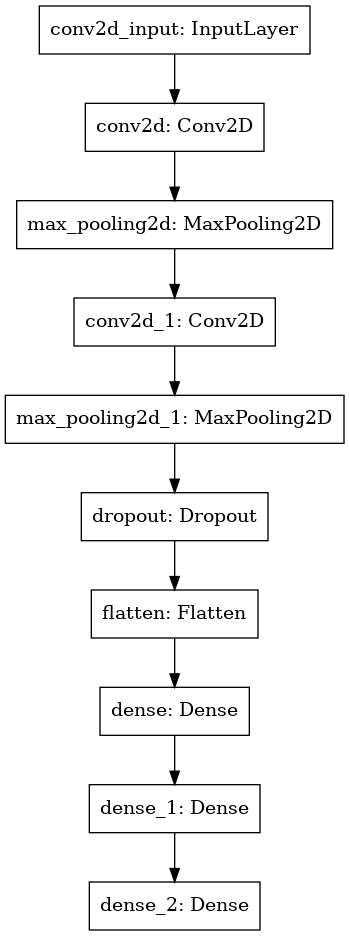

In [15]:
plot_model(model, to_file='MelSpectrogram-CNN-2D-model.png')

In [17]:
X, y = returnDataArr(data)

In [19]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
histories = []
hist_dict = []
for train_index, val_index in skf.split(np.zeros(len(X_train)),y_train):
    NAME = "{}-Fold_CV-{}".format(fold, int(time.time()))
    tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
#     print(NAME)

    X_train_cv = X_train[train_index]
    X_test_cv = X_train[val_index]
    
    y_train_cv = y_train[train_index]
    y_test_cv = y_train[val_index]
    

    hist = model.fit(X_train_cv, y_train_cv, batch_size=32, epochs=20, validation_data=(X_test_cv, y_test_cv), callbacks=[tensorboard])
    
    val_acc_mean = np.mean(hist.history['val_accuracy'])
    val_precision_mean = np.mean(hist.history['val_precision'])
    val_recall_mean = np.mean(hist.history['val_recall'])
    
    print(NAME, val_acc_mean, val_precision_mean, val_recall_mean)
    
    histories.append(hist.history)
    hist_dict.append(hist)

    fold += 1

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


272/272 [==============================] - 29s 103ms/step - loss: 0.6730 - accuracy: 0.5903 - precision: 0.4193 - recall: 0.1429 - val_loss: 0.6647 - val_accuracy: 0.6033 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
272/272 [==============================] - 27s 99ms/step - loss: 0.6606 - accuracy: 0.6114 - precision: 0.5189 - recall: 0.0123 - val_loss: 0.6425 - val_accuracy: 0.6341 - val_precision: 0.9119 - val_recall: 0.0876
Epoch 3/20
272/272 [==============================] - 27s 98ms/step - loss: 0.6400 - accuracy: 0.6414 - precision: 0.7449 - recall: 0.1288 - val_loss: 0.6239 - val_accuracy: 0.6484 - val_precision: 0.7182 - val_recall: 0.2000
Epoch 4/20
272/272 [==============================] - 27s 98ms/step - loss: 0.6271 - accuracy: 0.6514 - precision: 0.6049 - recall: 0.1913 - val_loss: 0.6074 - val_accuracy: 0.6576 - val_precision: 0.7235 - val_recall: 0.2319
Epoch 5/20
272/272 [==============================] - 27s 98ms/step - loss: 0.6098 - accuracy: 0.6

272/272 [==============================] - 27s 98ms/step - loss: 0.2692 - accuracy: 0.8951 - precision: 0.8954 - recall: 0.8246 - val_loss: 0.3208 - val_accuracy: 0.8683 - val_precision: 0.9586 - val_recall: 0.7079
Epoch 8/20
272/272 [==============================] - 27s 98ms/step - loss: 0.2666 - accuracy: 0.8986 - precision: 0.9035 - recall: 0.8287 - val_loss: 0.2805 - val_accuracy: 0.8854 - val_precision: 0.8532 - val_recall: 0.8562
Epoch 9/20
272/272 [==============================] - 27s 98ms/step - loss: 0.2629 - accuracy: 0.8987 - precision: 0.9016 - recall: 0.8389 - val_loss: 0.2896 - val_accuracy: 0.8780 - val_precision: 0.9112 - val_recall: 0.7617
Epoch 10/20
272/272 [==============================] - 27s 98ms/step - loss: 0.2607 - accuracy: 0.9001 - precision: 0.8955 - recall: 0.8419 - val_loss: 0.2728 - val_accuracy: 0.8835 - val_precision: 0.8713 - val_recall: 0.8264
Epoch 11/20
272/272 [==============================] - 27s 98ms/step - loss: 0.2653 - accuracy: 0.8984 - p

In [20]:
for history in histories:
    print("**************")
    print("accuracy - {}".format(np.mean(history['val_accuracy'])))
    print("precesion - {}".format(np.mean(history['val_precision'])))
    print("recall - {}".format(np.mean(history['val_recall'])))
    print("**************")

**************
accuracy - 0.7447998195886611
precesion - 0.7626070886850357
recall - 0.5040061827749014
**************
**************
accuracy - 0.8525770753622055
precesion - 0.8752587735652924
recall - 0.7700041115283967
**************
**************
accuracy - 0.8700184136629104
precesion - 0.884133380651474
recall - 0.8115018486976624
**************
**************
accuracy - 0.8762430906295776
precesion - 0.8856086641550064
recall - 0.8002535581588746
**************
**************
accuracy - 0.9211556196212769
precesion - 0.9396168112754821
recall - 0.8674345940351487
**************


In [21]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)
print(val_loss, val_accuracy, val_precision, val_recall)

38/38 [==============================] - 2s 51ms/step - loss: 0.2807 - accuracy: 0.8882 - precision: 0.8837 - recall: 0.8720
0.2806726098060608 0.8881524205207825 0.883686363697052 0.8719674944877625


In [75]:
## Validating against the validation dataset

#testing the Conv1D model
y_pred_prob = model.predict(X_test)
y_pred_classes = model.predict_classes(X_test)


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [76]:
#testing the Conv1D model
y_pred_prob = model.predict(X_test)
y_pred_classes = model.predict_classes(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_classes)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_classes)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_classes)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_pred_classes)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes)
print(matrix)

Accuracy: 0.872411
Precision: 0.781982
Recall: 0.929336
F1 score: 0.849315
Cohens kappa: 0.740098
ROC AUC: 0.956485
[[619 121]
 [ 33 434]]


##### Mel Spectrogram - VGG16

In [20]:
import keras_metrics


NAME = "VGG16-{}".format(int(time.time()))
print(NAME)
tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])


for layer in conv_base.layers:
    layer.trainable = False


top_model = conv_base.output
top_model = Flatten()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
output_layer = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=conv_base.input, outputs=output_layer)

model.summary()

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=5000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)
# opt = SGD(lr=0.0005)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])


VGG16-1623528172
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50

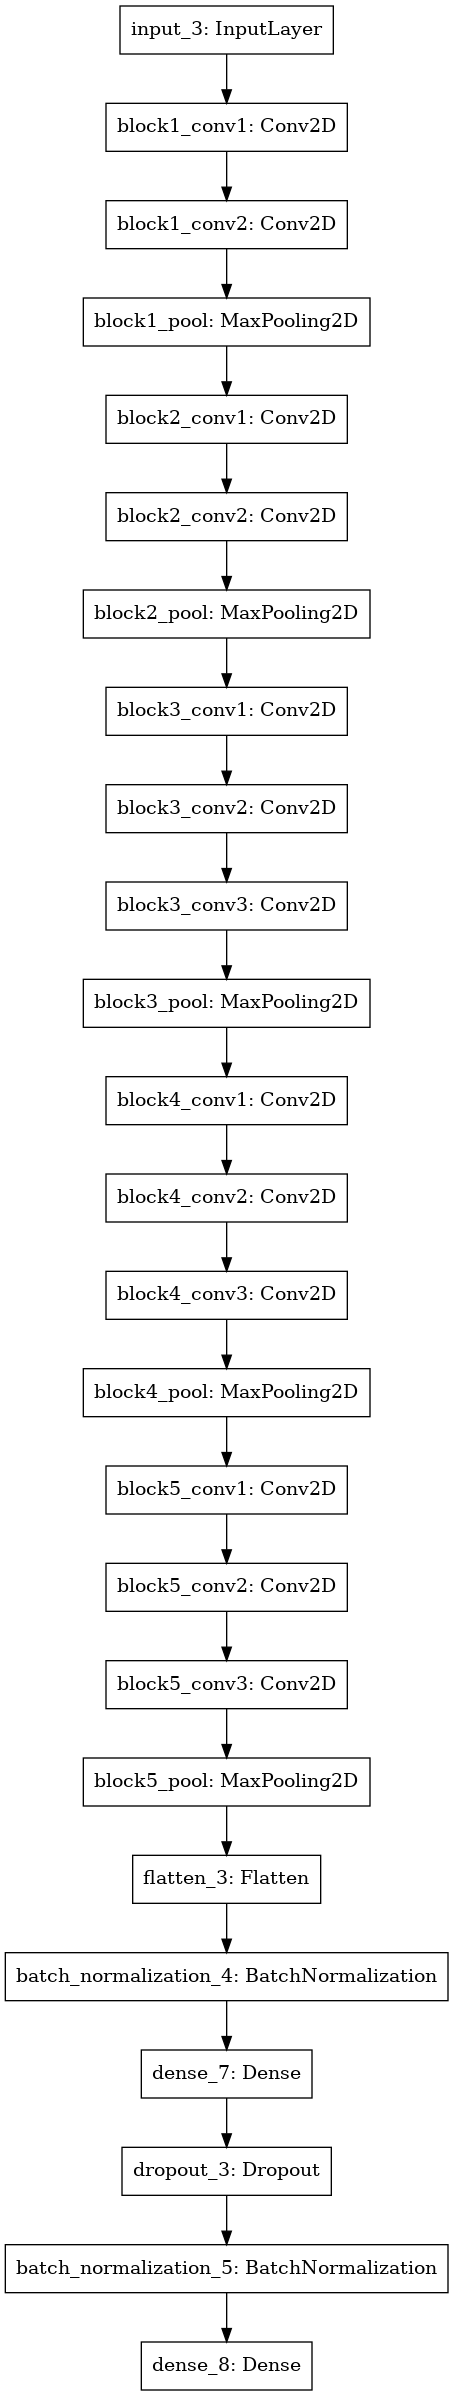

In [21]:
plot_model(model, to_file='MelSpectrogram-VGG16-model.png')

In [30]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
histories = []
for train_index, val_index in skf.split(np.zeros(len(X_train)),y_train):
    NAME = "VGG16-{}-CV_FOLD-VGG16-{}".format(fold, int(time.time()))
    tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
    print(NAME)

    X_train_cv = X_train[train_index]
    X_test_cv = X_train[val_index]
    
    y_train_cv = y_train[train_index]
    y_test_cv = y_train[val_index]
    

    hist = model.fit(X_train_cv, y_train_cv, batch_size=32, epochs=20, validation_data=(X_test_cv, y_test_cv), callbacks=[tensorboard])
    
    val_acc_mean = np.mean(hist.history['val_accuracy'])
    val_precision_mean = np.mean(hist.history['val_precision'])
    val_recall_mean = np.mean(hist.history['val_recall'])
    
    print("{}-run".format(fold), val_acc_mean, val_precision_mean, val_recall_mean)
    
    histories.append(hist.history)

    fold += 1

VGG16-1-CV_FOLD-VGG16-1623483575
Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


272/272 [==============================] - 39s 139ms/step - loss: 0.8341 - accuracy: 0.5300 - precision: 0.4229 - recall: 0.5268 - val_loss: 0.6126 - val_accuracy: 0.7018 - val_precision: 0.7079 - val_recall: 0.4676
Epoch 2/20
272/272 [==============================] - 36s 132ms/step - loss: 0.7296 - accuracy: 0.6007 - precision: 0.5025 - recall: 0.6154 - val_loss: 0.5797 - val_accuracy: 0.7119 - val_precision: 0.6410 - val_recall: 0.7124
Epoch 3/20
272/272 [==============================] - 36s 132ms/step - loss: 0.6793 - accuracy: 0.6456 - precision: 0.5422 - recall: 0.6822 - val_loss: 0.5645 - val_accuracy: 0.7234 - val_precision: 0.6532 - val_recall: 0.7263
Epoch 4/20
272/272 [==============================] - 36s 133ms/step - loss: 0.6441 - accuracy: 0.6708 - precision: 0.5566 - recall: 0.6867 - val_loss: 0.5520 - val_accuracy: 0.7299 - val_precision: 0.6597 - val_recall: 0.7252
Epoch 5/20
272/272 [==============================] - 36s 132ms/step - loss: 0.6275 - accuracy: 0.6754 

Epoch 11/20
272/272 [==============================] - 36s 132ms/step - loss: 0.4639 - accuracy: 0.7840 - precision: 0.7124 - recall: 0.7587 - val_loss: 0.3888 - val_accuracy: 0.8297 - val_precision: 0.7830 - val_recall: 0.8290
Epoch 12/20
272/272 [==============================] - 36s 132ms/step - loss: 0.4679 - accuracy: 0.7818 - precision: 0.7097 - recall: 0.7568 - val_loss: 0.3885 - val_accuracy: 0.8288 - val_precision: 0.7812 - val_recall: 0.8290
Epoch 13/20
272/272 [==============================] - 36s 132ms/step - loss: 0.4582 - accuracy: 0.7916 - precision: 0.7464 - recall: 0.7592 - val_loss: 0.3880 - val_accuracy: 0.8288 - val_precision: 0.7815 - val_recall: 0.8306
Epoch 14/20
272/272 [==============================] - 36s 132ms/step - loss: 0.4576 - accuracy: 0.7863 - precision: 0.7263 - recall: 0.7622 - val_loss: 0.3844 - val_accuracy: 0.8311 - val_precision: 0.7868 - val_recall: 0.8251
Epoch 15/20
272/272 [==============================] - 36s 132ms/step - loss: 0.4478 - a

MemoryError: Unable to allocate 7.77 GiB for an array with shape (8691, 200, 200, 3) and data type float64

In [ ]:
for history in histories:
    print("**************")
    print("accuracy - {}".format(np.mean(history['val_accuracy'])))
    print("precesion - {}".format(np.mean(history['val_precision'])))
    print("recall - {}".format(np.mean(history['val_recall'])))
    print("**************")

In [ ]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)
print(val_loss, val_accuracy, val_precision, val_recall)

In [38]:
#testing the Conv1D model
y_pred_prob = model.predict(X_test)
# y_pred_classes = model.predict_classes(X_test)
y_pred_classes = np.round(y_pred_prob).astype(int)
y_pred_classes_flat = y_pred_classes.flatten()

In [44]:
#testing the Conv1D model
y_pred_prob = model.predict(X_test)
# y_pred_classes = model.predict_classes(X_test)
y_pred_classes = np.round(y_pred_prob).astype(int)
y_pred_classes_flat = y_pred_classes.flatten()

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred_classes_flat)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred_classes_flat)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred_classes_flat)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred_classes_flat)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, y_pred_classes_flat)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes_flat)
print(matrix)

Accuracy: 0.870754
Precision: 0.845977
Recall: 0.805252
F1 score: 0.825112
Cohens kappa: 0.722714
ROC AUC: 0.933984
[[683  67]
 [ 89 368]]


###### ResNet50 Transfer Learning

In [40]:
X, y = returnDataArr(data)

In [46]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10863, 200, 200, 3) (10863,) (1207, 200, 200, 3) (1207,)


In [7]:
import gc
gc.collect()

10086

In [2]:
# conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(200,200,3))


for layer in conv_base.layers:
    layer.trainable = False


top_model = conv_base.output
top_model = Flatten()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
output_layer = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=conv_base.input, outputs=output_layer)

model.summary()

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.0002,
    decay_steps=5000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])
# 



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

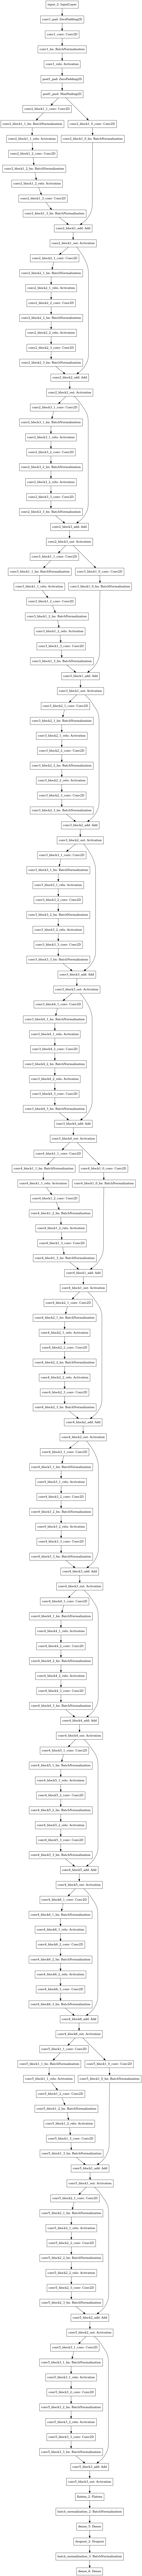

In [19]:
plot_model(model, to_file='MelSpectrogram-ResNet50-model.png')

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
histories = []
for train_index, val_index in skf.split(np.zeros(len(X_train)),y_train):
    print("****Modelling Starts*****")
    X_train_cv = X_train[train_index]
    X_test_cv = X_train[val_index]
    
    y_train_cv = y_train[train_index]
    y_test_cv = y_train[val_index]

    
    hist = model.fit(X_train_cv, y_train_cv, batch_size=32, epochs=20, validation_data=(X_test_cv, y_test_cv))
    
    val_acc_mean = np.mean(hist.history['val_accuracy'])
    val_precision_mean = np.mean(hist.history['val_precision'])
    val_recall_mean = np.mean(hist.history['val_recall'])
    
    print("{}-run".format(fold), val_acc_mean, val_precision_mean, val_recall_mean)
    
    histories.append(hist.history)
    
    fold += 1

****Modelling Starts*****
Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


272/272 [==============================] - 35s 115ms/step - loss: 0.6775 - accuracy: 0.6429 - precision: 0.4929 - recall: 0.6157 - val_loss: 0.5910 - val_accuracy: 0.6926 - val_precision: 0.5983 - val_recall: 0.8749
Epoch 2/20
272/272 [==============================] - 29s 105ms/step - loss: 0.5225 - accuracy: 0.7502 - precision: 0.6519 - recall: 0.7373 - val_loss: 0.4364 - val_accuracy: 0.8030 - val_precision: 0.7665 - val_recall: 0.7527
Epoch 3/20
272/272 [==============================] - 29s 106ms/step - loss: 0.4920 - accuracy: 0.7666 - precision: 0.6838 - recall: 0.7490 - val_loss: 0.4115 - val_accuracy: 0.8132 - val_precision: 0.7988 - val_recall: 0.7385
Epoch 4/20
272/272 [==============================] - 29s 108ms/step - loss: 0.4803 - accuracy: 0.7826 - precision: 0.7122 - recall: 0.7396 - val_loss: 0.4042 - val_accuracy: 0.8210 - val_precision: 0.8078 - val_recall: 0.7521
Epoch 5/20
272/272 [==============================] - 29s 108ms/step - loss: 0.4484 - accuracy: 0.8003 

Epoch 11/20
272/272 [==============================] - 29s 108ms/step - loss: 0.2843 - accuracy: 0.8832 - precision: 0.8575 - recall: 0.8568 - val_loss: 0.2640 - val_accuracy: 0.8937 - val_precision: 0.8962 - val_recall: 0.8267
Epoch 12/20
272/272 [==============================] - 29s 108ms/step - loss: 0.2823 - accuracy: 0.8815 - precision: 0.8665 - recall: 0.8411 - val_loss: 0.2635 - val_accuracy: 0.8928 - val_precision: 0.9092 - val_recall: 0.8159
Epoch 13/20
272/272 [==============================] - 29s 108ms/step - loss: 0.2753 - accuracy: 0.8890 - precision: 0.8654 - recall: 0.8505 - val_loss: 0.2684 - val_accuracy: 0.8942 - val_precision: 0.9124 - val_recall: 0.8312
Epoch 14/20
272/272 [==============================] - 29s 108ms/step - loss: 0.2756 - accuracy: 0.8853 - precision: 0.8611 - recall: 0.8371 - val_loss: 0.2654 - val_accuracy: 0.8932 - val_precision: 0.8982 - val_recall: 0.8118
Epoch 15/20
272/272 [==============================] - 29s 108ms/step - loss: 0.2707 - a

In [45]:
for history in histories:
    print("**************")
    print("accuracy - {}".format(np.mean(history['val_accuracy'])))
    print("precesion - {}".format(np.mean(history['val_precision'])))
    print("recall - {}".format(np.mean(history['val_recall'])))
    print("**************")

**************
accuracy - 0.8387022584676742
precesion - 0.8277287721633911
recall - 0.8037506520748139
**************
**************
accuracy - 0.8777496606111527
precesion - 0.8708111137151718
recall - 0.7836937993764878
**************
**************
accuracy - 0.9200874328613281
precesion - 0.9296211004257202
recall - 0.8685654014348984
**************
**************
accuracy - 0.934691521525383
precesion - 0.9499364525079728
recall - 0.8928908735513688
**************
**************
accuracy - 0.9410221010446549
precesion - 0.943686506152153
recall - 0.8988132655620575
**************


In [46]:
X_test = X_test/255.0

In [47]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)
print(val_loss, val_accuracy, val_precision, val_recall)

38/38 [==============================] - 3s 85ms/step - loss: 0.2617 - accuracy: 0.8948 - precision: 0.9220 - recall: 0.8070
0.2617175281047821 0.8947804570198059 0.9220103025436401 0.8069890141487122


### Getting Gammatonegram & Preparing Data for Deep Learning

In [8]:
test_train_split = 0.1
img_size = 200
data = []
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Read Text/HC/Gammatonegram')
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Read Text/PD/Gammatonegram')
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Spontaneous/HC/Gammatonegram')
data = getData('/home/akshayrauthan0806/Research - PD/Spectograms/Spontaneous/PD/Gammatonegram')

In [9]:
print(len(data))

11998


In [10]:
def returnTestTrain(dataArr):
    X = []
    y = []
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for feature, label in data:
        X.append(feature)
        y.append(label)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_train_split)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X = np.array(X)
    y = np.array(y)
    
#     return X, y, X_train, y_train, X_test, y_test
    return X_train, y_train, X_test, y_test

In [11]:
X_train, y_train, X_test, y_test = returnTestTrain(data)
# print(X.shape, y.shape)

In [12]:
# X = X.astype(float)
# y = y.astype(float)
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [10]:
# Normalize Data
# X_train = X_train/255.0
# X_test = X_test/255.0
# X = X/255.0

###### CNN - Conv2D

In [14]:
import keras_metrics
dense_layer = 2
layer_size = 128
conv_layer = 2


model = Sequential()
model.add(Conv2D(layer_size, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPool2D())

for l in range(conv_layer-1):
    model.add(Conv2D(layer_size, 3, padding="same", activation="relu"))
    model.add(MaxPool2D())

model.add(Dropout(0.4))

model.add(Flatten())

for d in range(dense_layer):
    model.add(Dense(layer_size,activation="relu"))

model.add(Dense(1, activation="sigmoid"))

model.summary()

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])
# hist = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[tensorboard])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 307328)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

In [15]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
histories = []
for train_index, val_index in skf.split(np.zeros(len(X_train)),y_train):
    NAME = "{}-Fold_CV-{}".format(fold, int(time.time()))
    tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
#     print(NAME)

    X_train_cv = X_train[train_index]
    X_test_cv = X_train[val_index]
    
    y_train_cv = y_train[train_index]
    y_test_cv = y_train[val_index]

    
    X_train_cv, X_test_cv, y_train_cv, y_test_cv = convertToFloat(X_train_cv, X_test_cv, y_train_cv, y_test_cv)
    
    X_train_cv = X_train_cv/255.0
    X_test_cv = X_test_cv/255.0    
    

    hist = model.fit(X_train_cv, y_train_cv, batch_size=32, epochs=20, validation_data=(X_test_cv, y_test_cv), callbacks=[tensorboard])
    
    val_acc_mean = np.mean(hist.history['val_accuracy'])
    val_precision_mean = np.mean(hist.history['val_precision'])
    val_recall_mean = np.mean(hist.history['val_recall'])
    
    print(NAME, val_acc_mean, val_precision_mean, val_recall_mean)
    
    histories.append(hist.history)

    fold += 1

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


270/270 [==============================] - 36s 114ms/step - loss: 0.6717 - accuracy: 0.6001 - precision: 0.3963 - recall: 0.0449 - val_loss: 0.6580 - val_accuracy: 0.6037 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
270/270 [==============================] - 26s 98ms/step - loss: 0.6518 - accuracy: 0.6164 - precision: 0.5743 - recall: 0.0508 - val_loss: 0.6176 - val_accuracy: 0.6560 - val_precision: 0.9228 - val_recall: 0.1490
Epoch 3/20
270/270 [==============================] - 27s 99ms/step - loss: 0.6100 - accuracy: 0.6780 - precision: 0.7900 - recall: 0.2084 - val_loss: 0.5805 - val_accuracy: 0.7398 - val_precision: 0.7400 - val_recall: 0.4994
Epoch 4/20
270/270 [==============================] - 27s 99ms/step - loss: 0.5766 - accuracy: 0.7198 - precision: 0.7471 - recall: 0.4382 - val_loss: 0.5439 - val_accuracy: 0.7449 - val_precision: 0.8194 - val_recall: 0.4143
Epoch 5/20
270/270 [==============================] - 27s 98ms/step - loss: 0.5510 - accuracy: 0.7

Epoch 11/20
270/270 [==============================] - 27s 98ms/step - loss: 0.4481 - accuracy: 0.8016 - precision: 0.8094 - recall: 0.6448 - val_loss: 0.4455 - val_accuracy: 0.7991 - val_precision: 0.8693 - val_recall: 0.6091
Epoch 12/20
270/270 [==============================] - 27s 99ms/step - loss: 0.4494 - accuracy: 0.8010 - precision: 0.8125 - recall: 0.6535 - val_loss: 0.4375 - val_accuracy: 0.8000 - val_precision: 0.8231 - val_recall: 0.6825
Epoch 13/20
270/270 [==============================] - 27s 99ms/step - loss: 0.4467 - accuracy: 0.8023 - precision: 0.8135 - recall: 0.6473 - val_loss: 0.4376 - val_accuracy: 0.7995 - val_precision: 0.8546 - val_recall: 0.6353
Epoch 14/20
270/270 [==============================] - 27s 98ms/step - loss: 0.4440 - accuracy: 0.8020 - precision: 0.8081 - recall: 0.6554 - val_loss: 0.4354 - val_accuracy: 0.8000 - val_precision: 0.8068 - val_recall: 0.7046
Epoch 15/20
270/270 [==============================] - 27s 99ms/step - loss: 0.4420 - accura

In [16]:
for history in histories:
    print("**************")
    print("accuracy - {}".format(np.mean(history['val_accuracy'])))
    print("precesion - {}".format(np.mean(history['val_precision'])))
    print("recall - {}".format(np.mean(history['val_recall'])))
    print("**************")

**************
accuracy - 0.7600925922393799
precesion - 0.7704352825880051
recall - 0.5082099877297879
**************
**************
accuracy - 0.7968981504440308
precesion - 0.8374320566654205
recall - 0.6532505214214325
**************
**************
accuracy - 0.8176620364189148
precesion - 0.8314563632011414
recall - 0.7190852791070939
**************
**************
accuracy - 0.8447892516851425
precesion - 0.8850523918867111
recall - 0.7341739267110825
**************
**************
accuracy - 0.8455303400754929
precesion - 0.8772085994482041
recall - 0.7300057679414749
**************


In [17]:
X_test = X_test/255.0

In [18]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)
print(val_loss, val_accuracy, val_precision, val_recall)

38/38 [==============================] - 1s 27ms/step - loss: 0.3784 - accuracy: 0.8225 - precision: 0.8264 - recall: 0.6901
0.37839019298553467 0.8224999904632568 0.8264191746711731 0.6900582313537598


In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

###### VGG16

In [14]:
import keras_metrics


NAME = "VGG16-{}".format(int(time.time()))
print(NAME)
tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])



for layer in conv_base.layers:
    layer.trainable = False

top_model = conv_base.output
top_model = Flatten()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
output_layer = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=conv_base.input, outputs=output_layer)

model.summary()

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=5000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

VGG16-1622580153
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50

In [15]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
histories = []
for train_index, val_index in skf.split(np.zeros(len(X_train)),y_train):
    NAME = "{}-CV_FOLD-VGG16-{}".format(fold, int(time.time()))
    tensorboard = TensorBoard(log_dir='./logs_dir/{}'.format(NAME))
    print(NAME)

    X_train_cv = X_train[train_index]
    X_test_cv = X_train[val_index]
    
    y_train_cv = y_train[train_index]
    y_test_cv = y_train[val_index]
    
    
    X_train_cv, X_test_cv , y_train_cv, y_test_cv = convertToFloat(X_train_cv, X_test_cv, y_train_cv, y_test_cv)
    
    X_train_cv = X_train_cv/255.0
    X_test_cv = X_test_cv/255.0    

    hist = model.fit(X_train_cv, y_train_cv, batch_size=32, epochs=20, validation_data=(X_test_cv, y_test_cv), callbacks=[tensorboard])
    
    val_acc_mean = np.mean(hist.history['val_accuracy'])
    val_precision_mean = np.mean(hist.history['val_precision'])
    val_recall_mean = np.mean(hist.history['val_recall'])
    
    print("{}-run".format(fold), val_acc_mean, val_precision_mean, val_recall_mean)
    
    histories.append(hist.history)

    fold += 1

1-CV_FOLD-VGG16-1622580159
Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


270/270 [==============================] - 53s 166ms/step - loss: 0.8673 - accuracy: 0.5115 - precision: 0.3668 - recall: 0.4984 - val_loss: 0.6972 - val_accuracy: 0.5315 - val_precision: 0.4658 - val_recall: 0.8910
Epoch 2/20
270/270 [==============================] - 36s 134ms/step - loss: 0.7495 - accuracy: 0.6038 - precision: 0.4705 - recall: 0.5808 - val_loss: 0.6084 - val_accuracy: 0.6708 - val_precision: 0.5823 - val_recall: 0.7231
Epoch 3/20
270/270 [==============================] - 36s 132ms/step - loss: 0.6835 - accuracy: 0.6424 - precision: 0.5430 - recall: 0.6619 - val_loss: 0.5761 - val_accuracy: 0.7046 - val_precision: 0.6272 - val_recall: 0.6925
Epoch 4/20
270/270 [==============================] - 36s 133ms/step - loss: 0.6729 - accuracy: 0.6590 - precision: 0.5714 - recall: 0.6496 - val_loss: 0.5645 - val_accuracy: 0.7162 - val_precision: 0.6407 - val_recall: 0.7042
Epoch 5/20
270/270 [==============================] - 36s 133ms/step - loss: 0.6167 - accuracy: 0.6916 

Epoch 11/20
270/270 [==============================] - 36s 133ms/step - loss: 0.4837 - accuracy: 0.7755 - precision: 0.6934 - recall: 0.7537 - val_loss: 0.4015 - val_accuracy: 0.8199 - val_precision: 0.7774 - val_recall: 0.7550
Epoch 12/20
270/270 [==============================] - 36s 133ms/step - loss: 0.4836 - accuracy: 0.7771 - precision: 0.7231 - recall: 0.7546 - val_loss: 0.4006 - val_accuracy: 0.8213 - val_precision: 0.7847 - val_recall: 0.7528
Epoch 13/20
270/270 [==============================] - 36s 133ms/step - loss: 0.4875 - accuracy: 0.7701 - precision: 0.7101 - recall: 0.7374 - val_loss: 0.4003 - val_accuracy: 0.8185 - val_precision: 0.7802 - val_recall: 0.7549
Epoch 14/20
270/270 [==============================] - 36s 133ms/step - loss: 0.4800 - accuracy: 0.7731 - precision: 0.6991 - recall: 0.7469 - val_loss: 0.3974 - val_accuracy: 0.8218 - val_precision: 0.7911 - val_recall: 0.7403
Epoch 15/20
270/270 [==============================] - 36s 133ms/step - loss: 0.4792 - a

In [16]:
for history in histories:
    print("**************")
    print("accuracy - {}".format(np.mean(history['val_accuracy'])))
    print("precesion - {}".format(np.mean(history['val_precision'])))
    print("recall - {}".format(np.mean(history['val_recall'])))
    print("**************")

**************
accuracy - 0.735486114025116
precesion - 0.6652661189436913
recall - 0.7224130749702453
**************
**************
accuracy - 0.8188425958156585
precesion - 0.7779116272926331
recall - 0.7499490320682526
**************
**************
accuracy - 0.8583101838827133
precesion - 0.8345735192298889
recall - 0.8238193392753601
**************
**************
accuracy - 0.8694997638463974
precesion - 0.8517609357833862
recall - 0.7805858880281449
**************
**************
accuracy - 0.8872394531965255
precesion - 0.8837446600198746
recall - 0.8284306466579437
**************


In [17]:
X_test = X_test/255.0

In [18]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)
print(val_loss, val_accuracy, val_precision, val_recall)

38/38 [==============================] - 4s 104ms/step - loss: 0.4251 - accuracy: 0.8267 - precision: 0.8135 - recall: 0.7393
0.4251180589199066 0.8266666531562805 0.8134855628013611 0.7393021583557129


###### ResNet50

In [13]:
# conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(200,200,3))


for layer in conv_base.layers:
    layer.trainable = False

top_model = conv_base.output
top_model = Flatten()(top_model)
top_model = BatchNormalization()(top_model)
top_model = Dense(256, activation='relu')(top_model)
top_model = Dropout(0.5)(top_model)
top_model = BatchNormalization()(top_model)
output_layer = Dense(1, activation='sigmoid')(top_model)

model = Model(inputs=conv_base.input, outputs=output_layer)

model.summary()

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=5000,
    decay_rate=0.9)
opt = SGD(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 100, 100, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [14]:
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)
fold = 1
histories = []
for train_index, val_index in skf.split(np.zeros(len(X_train)),y_train):
    print("****Modelling Starts*****")
    X_train_cv = X_train[train_index]
    X_test_cv = X_train[val_index]
    
    y_train_cv = y_train[train_index]
    y_test_cv = y_train[val_index]

    
    X_train_cv, X_test_cv , y_train_cv, y_test_cv = convertToFloat(X_train_cv, X_test_cv, y_train_cv, y_test_cv)
    
    X_train_cv = X_train_cv/255.0
    X_test_cv = X_test_cv/255.0    
    
    
    hist = model.fit(X_train_cv, y_train_cv, batch_size=32, epochs=20, validation_data=(X_test_cv, y_test_cv))
    
    val_acc_mean = np.mean(hist.history['val_accuracy'])
    val_precision_mean = np.mean(hist.history['val_precision'])
    val_recall_mean = np.mean(hist.history['val_recall'])
    
    print("{}-run".format(fold), val_acc_mean, val_precision_mean, val_recall_mean)
    
    histories.append(hist.history)
    
    fold += 1

****Modelling Starts*****
Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1402: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


270/270 [==============================] - 39s 121ms/step - loss: 0.7366 - accuracy: 0.6021 - precision: 0.4714 - recall: 0.5662 - val_loss: 0.5817 - val_accuracy: 0.7194 - val_precision: 0.7103 - val_recall: 0.4817
Epoch 2/20
270/270 [==============================] - 30s 111ms/step - loss: 0.6423 - accuracy: 0.6808 - precision: 0.5561 - recall: 0.6744 - val_loss: 0.5231 - val_accuracy: 0.7579 - val_precision: 0.7192 - val_recall: 0.6601
Epoch 3/20
270/270 [==============================] - 30s 112ms/step - loss: 0.6075 - accuracy: 0.7036 - precision: 0.6246 - recall: 0.6711 - val_loss: 0.5235 - val_accuracy: 0.7509 - val_precision: 0.6911 - val_recall: 0.7227
Epoch 4/20
270/270 [==============================] - 30s 111ms/step - loss: 0.5952 - accuracy: 0.7154 - precision: 0.6444 - recall: 0.6956 - val_loss: 0.5094 - val_accuracy: 0.7634 - val_precision: 0.7134 - val_recall: 0.7177
Epoch 5/20
270/270 [==============================] - 30s 112ms/step - loss: 0.5763 - accuracy: 0.7230 

Epoch 11/20
270/270 [==============================] - 30s 112ms/step - loss: 0.4151 - accuracy: 0.8137 - precision: 0.7593 - recall: 0.7652 - val_loss: 0.3703 - val_accuracy: 0.8500 - val_precision: 0.8525 - val_recall: 0.8079
Epoch 12/20
270/270 [==============================] - 30s 112ms/step - loss: 0.4107 - accuracy: 0.8136 - precision: 0.7561 - recall: 0.7600 - val_loss: 0.3648 - val_accuracy: 0.8556 - val_precision: 0.8605 - val_recall: 0.8114
Epoch 13/20
270/270 [==============================] - 30s 112ms/step - loss: 0.4065 - accuracy: 0.8150 - precision: 0.7572 - recall: 0.7721 - val_loss: 0.3698 - val_accuracy: 0.8551 - val_precision: 0.8670 - val_recall: 0.7968
Epoch 14/20
270/270 [==============================] - 30s 112ms/step - loss: 0.4091 - accuracy: 0.8159 - precision: 0.7853 - recall: 0.7618 - val_loss: 0.3689 - val_accuracy: 0.8523 - val_precision: 0.8624 - val_recall: 0.8016
Epoch 15/20
270/270 [==============================] - 30s 112ms/step - loss: 0.3891 - a

In [16]:
for history in histories:
    print("**************")
    print("accuracy - {}".format(np.mean(history['val_accuracy'])))
    print("precesion - {}".format(np.mean(history['val_precision'])))
    print("recall - {}".format(np.mean(history['val_recall'])))
    print("**************")

**************
accuracy - 0.781597226858139
precesion - 0.739088100194931
recall - 0.7046900585293769
**************
**************
accuracy - 0.8498611062765121
precesion - 0.8508876204490662
recall - 0.8019931793212891
**************
**************
accuracy - 0.869074073433876
precesion - 0.8613160789012909
recall - 0.7992075562477112
**************
**************
accuracy - 0.8869383960962296
precesion - 0.8947121977806092
recall - 0.8267323106527329
**************
**************
accuracy - 0.9069708228111267
precesion - 0.9156129568815231
recall - 0.8394868910312653
**************


In [17]:
X_test = X_test/255.0

In [18]:
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(X_test, y_test)
print(val_loss, val_accuracy, val_precision, val_recall)

38/38 [==============================] - 3s 85ms/step - loss: 0.3914 - accuracy: 0.8275 - precision: 0.8384 - recall: 0.7372
0.3913612961769104 0.8274999856948853 0.8383822441101074 0.7372348308563232
